In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/My Drive/Emotion Detection Project"


/content/drive/My Drive/Emotion Detection Project


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load Dataset
df = pd.read_csv('combined_emotion.csv')
texts = df["sentence"].values
labels = df["emotion"].values

# Label Encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenization
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')




In [ ]:
# Load Word2Vec Embeddings
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("word2vec_model.bin")

embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words and word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# CNN + BiLSTM Model
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=max_words,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)(input_layer)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:

# CNN Branch
cnn = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(embedding_layer)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = GlobalMaxPooling1D()(cnn)

# BiLSTM Branch
bilstm = Bidirectional(LSTM(128, return_sequences=False))(embedding_layer)

# Concatenate CNN + BiLSTM Outputs
merged = Concatenate()([cnn, bilstm])
merged = Dense(128, activation='relu')(merged)
merged = Dropout(0.5)(merged)

# Output Layer (Emotion Prediction)
output_layer = Dense(len(np.unique(labels)), activation='softmax')(merged)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train Model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 100)       │      1,000,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 100, 128)       │         64,128 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 50, 128)        │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 128)            │              0 │ max_pooling1d[0][0]    │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 256)            │        234,496 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 384)            │              0 │ global_max_pooling1d[… │
│                           │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         49,280 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 6)              │            774 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,348,678 (5.14 MB)

 Trainable params: 348,678 (1.33 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 168s 15ms/step - accuracy: 0.8590 - loss: 0.3665 - val_accuracy: 0.9347 - val_loss: 0.1111
Epoch 2/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 163s 15ms/step - accuracy: 0.9359 - loss: 0.1145 - val_accuracy: 0.9374 - val_loss: 0.1021
Epoch 3/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 159s 15ms/step - accuracy: 0.9383 - loss: 0.1041 - val_accuracy: 0.9374 - val_loss: 0.1014
Epoch 4/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 209s 16ms/step - accuracy: 0.9389 - loss: 0.1009 - val_accuracy: 0.9378 - val_loss: 0.0984
Epoch 5/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 202s 16ms/step - accuracy: 0.9388 - loss: 0.0975 - val_accuracy: 0.9389 - val_loss: 0.1003
Epoch 6/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 167s 16ms/step - accuracy: 0.9399 - loss: 0.0960 - val_accuracy: 0.9380 - val_loss: 0.1038
Epoch 7/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 202s 16ms/step - accuracy: 0.9403 - loss: 0.0956 - val_accuracy: 0.9402 - val_loss: 0.1019
Epoch 8/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 202s 16ms/s

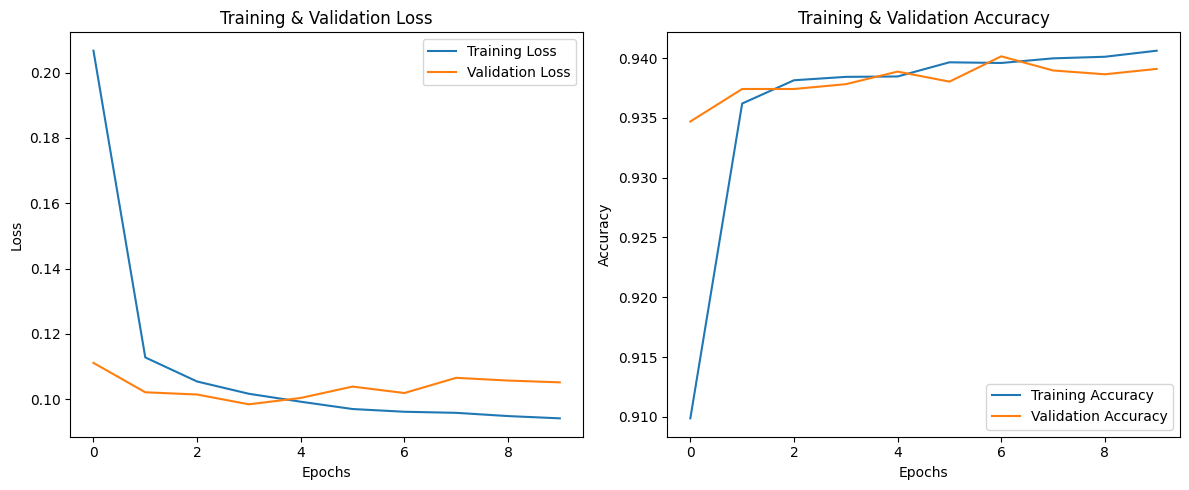

In [9]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from history object
history_dict = history.history

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy (if available)
if 'accuracy' in history_dict:  # Use 'acc' for older TensorFlow versions
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


In [10]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
predictions = model.predict(X_test_pad)
predicted_labels = np.argmax(predictions, axis=1)

# Decode predicted labels
predicted_emotions = label_encoder.inverse_transform(predicted_labels)


2643/2643 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9393 - loss: 0.1046
Test Accuracy: 0.9391
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step


In [11]:
def predict_emotion(sentence):
    # Load tokenizer and label encoder
    #with open("tokenizer.pkl", "rb") as file:
        #tokenizer = pickle.load(file)

    #with open("label_encoder.pkl", "rb") as file:
        #label_encoder = pickle.load(file)

    # Preprocess input sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Load model
    #model = tf.keras.models.load_model("emotion_lstm_model.h5")

    # Make prediction
    prediction = model.predict(padded_sequence)
    predicted_label = np.argmax(prediction)
    predicted_emotion = label_encoder.inverse_transform([predicted_label])[0]

    return predicted_emotion




In [14]:
# Example usage
example_sentences =  [
        "The weather is wonderful today!",
        "I am feeling really sad and lonely.",
        "What an exciting game we had last night!",
        "I can't believe how much I've learned this year!",
        "I was so angry during the meeting today.",
        "I can't believe how everything turned out today, it's a bit overwhelming.",
        "I guess I'm doing okay, but it's not as good as I hoped.",
        "That was such a fantastic presentation, even though I made some mistakes.",
        "I'm so glad I made it through the day, but I'm exhausted!",
        "I can't stop thinking about how much better things could have been.",
        "It was a long day, but I had a lot of fun!",
        "My cat died today.",
        "I got hit by a car and factured my leg."
    ]

for i in example_sentences:
    print(i,":",predict_emotion(i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
The weather is wonderful today! : joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
I am feeling really sad and lonely. : sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
What an exciting game we had last night! : anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
I can't believe how much I've learned this year! : joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
I was so angry during the meeting today. : anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
I can't believe how everything turned out today, it's a bit overwhelming. : anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
I guess I'm doing okay, but it's not as good as I hoped. : joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
That was such a fantastic presentation, even though I made some mistakes. : joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
I'm so glad I made it through the day, but I'm exhausted! : joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
I can't stop thinking about how much better things could have been. : joy
1/1 ━━━━━━━━━━━━━━━━━━━━

2643/2643 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step


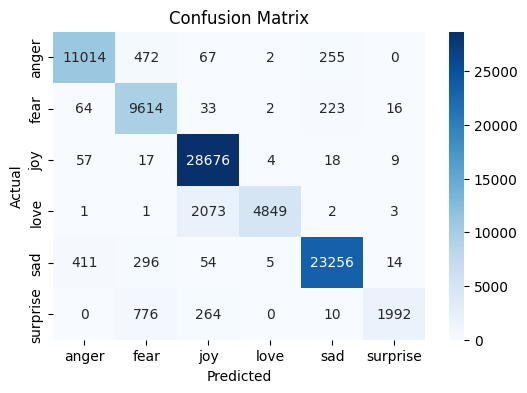

              precision    recall  f1-score   support

       anger       0.95      0.93      0.94     11810
        fear       0.86      0.97      0.91      9952
         joy       0.92      1.00      0.96     28781
        love       1.00      0.70      0.82      6929
         sad       0.98      0.97      0.97     24036
     suprise       0.98      0.65      0.78      3042

    accuracy                           0.94     84550
   macro avg       0.95      0.87      0.90     84550
weighted avg       0.94      0.94      0.94     84550



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data
y_pred = model.predict(X_test_pad)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1) if y_pred.shape[1] > 1 else (y_pred > 0.5).astype("int32")

# Now compute the confusion matrix
cm = confusion_matrix(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred_classes))
emotion_labels = ['anger', 'fear', 'joy', 'love', 'sad', 'surprise']

# Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=emotion_labels,yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred_classes)))


In [16]:
model.save('biLSTM+CNN.keras')